In [1]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import torchvision
import py7zr
from torch import nn
from PIL import Image
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 解压数据集

In [3]:
def extract_7z_file(filename, path):
    with py7zr.SevenZipFile(filename, 'r') as z:
        z.extractall(path)

In [25]:
extract_7z_file('/kaggle/input/cifar-10/train.7z', '/kaggle/working/train/')
extract_7z_file('/kaggle/input/cifar-10/test.7z', '/kaggle/working/test/')

# 预览数据集
定义图像和标签的路径

In [27]:
train_path = '/kaggle/input/cifar-10/trainLabels.csv'
train_img_dir = '/kaggle/working/train/train'
test_img_dir = '/kaggle/working/test/test'

预览trainLabels.csv

In [6]:
train_csv = pd.read_csv(train_path)
train_csv.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [7]:
len(train_csv)

50000

预览前8张图像

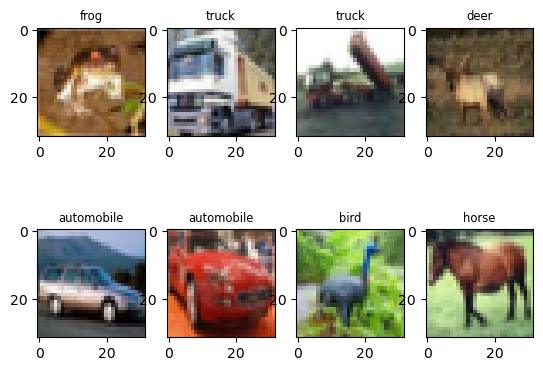

In [8]:
for i in range(8):
    image = Image.open(os.path.join(train_img_dir, str(train_csv.iloc[i, 0]) + '.png'))
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(train_csv.iloc[i, 1], fontsize='small')

图像大小为：32*32

In [9]:
image = Image.open(os.path.join(train_img_dir, str(train_csv.iloc[0, 0]) + '.png'))
image.size

(32, 32)

# 生成label和cls的映射

In [10]:
labels = sorted(list(set(train_csv['label'])))
len_labels = len(labels)
labels_cls_map = dict(zip(labels, range(len_labels)))
cls_labels_map = {v : k for k, v in labels_cls_map.items()}

# 定义训练使用到的工具方法
定义获取dataloader的使用进程数的方法

In [11]:
def get_dataloader_workers():
    """使用2个进程来读取数据"""
    return 2

定义获取gpu设备的方法

In [12]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

# 自定义类Dataset
* 训练Dataset: CIFAR10ImageDataset
* 测试Dataset: CIFAR10ImageTestDataset

In [13]:
class CIFAR10ImageDataset(Dataset):
    def __init__(self, X, y, root_dir: str, transform=None):
        self.X = X
        self.y = y
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.root_dir, str(self.X[idx]) + '.png')
        image = Image.open(img_path)
        label = labels_cls_map[self.y[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

class CIFAR10ImageTestDataset(Dataset):
    def __init__(self, annotations_file: str, root_dir: str, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self) -> int:
        return len(self.img_labels)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.root_dir, str(self.img_labels.iloc[idx, 0]) + '.png')
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

# 定义网络
使用torchVison.models的ResNet50模型

In [14]:
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [15]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [16]:
def get_net(nums_cls, train=True):
    net = resnet18(nums_cls, 3)
    return net

# 定义训练方法

In [17]:
def train_model(net, dataset_sizes, dataloaders, num_epochs, lr, devices, weight_decay):
    print('train_nums: ', dataset_sizes['train'])
    print('val_nums: ', dataset_sizes['val'])
    devices = [try_gpu(i) for i in devices]
    print('training on', devices)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    optimizer = torch.optim.SGD(net.parameters(), lr=lr,  momentum=0.9, weight_decay = weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    loss = nn.CrossEntropyLoss()
    best_model_params_path = 'best_model_params.pt'
    torch.save(net.state_dict(), best_model_params_path)
    best_acc = 0.0
    start_time = time.time()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            running_loss = 0.0
            running_corrects = 0
            for X, y in tqdm(dataloaders[phase]):
                optimizer.zero_grad()
                X, y = X.to(devices[0]), y.to(devices[0])
                with torch.set_grad_enabled(phase == 'train'):
                    y_hat = net(X)
                    _, preds = torch.max(y_hat, 1)
                    l = loss(y_hat, y)

                    if phase == 'train':        
                        l.backward()
                        optimizer.step()

                running_loss += l.item() * X.size(0)
                running_corrects += torch.sum(preds == y.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end='\n')
            if epoch % 10 ==0:
                torch.save(net.state_dict(), "model_"+ str(epoch) +".pth")
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(net.state_dict(), best_model_params_path)
        print()
    elapsed_time = time.time() - start_time
    print(f'Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}') 
    return net

# 划分训练集和验证集

In [18]:
X = train_csv.iloc[:, 0]
Y = train_csv.iloc[:, 1]
X_train, X_val, Y_train, Y_val = train_test_split(X.values, Y.values, test_size=0.2, random_state=759)

# 定义训练数据

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(40),
        transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #CIDAE-10数据集的均值和标准差
        transforms.Normalize([0.491, 0.482, 0.447], [0.247, 0.244, 0.262]
        )
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.491, 0.482, 0.447], [0.247, 0.244, 0.262]
        )
    ]),
}

data_set = {
    'train': CIFAR10ImageDataset(X_train, Y_train, train_img_dir, data_transforms['train']),
    'val': CIFAR10ImageDataset(X_val, Y_val, train_img_dir, data_transforms['val'])
}
dataset_sizes = {
    'train': len(data_set['train']),
    'val': len(data_set['val'])
}

# 训练

In [20]:
lr, num_epochs, batch_size,devices,weight_decay = 0.001, 100, 128, [0, 1], 1e-3
dataloaders = {
    'train': data.DataLoader(dataset=data_set['train'], batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers(), pin_memory=True),
    'val': data.DataLoader(dataset=data_set['val'], batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers(), pin_memory=False)
}
model = train_model(get_net(len(labels_cls_map), False), dataset_sizes, dataloaders, num_epochs, lr, devices, weight_decay)

train_nums:  40000
val_nums:  10000
training on [device(type='cuda', index=0), device(type='cuda', index=1)]
Epoch 0/99
----------


100%|██████████| 313/313 [00:51<00:00,  6.11it/s]


train Loss: 1.6234 Acc: 0.3994


100%|██████████| 79/79 [00:05<00:00, 14.64it/s]


val Loss: 1.4242 Acc: 0.4857

Epoch 1/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.30it/s]


train Loss: 1.2266 Acc: 0.5587


100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


val Loss: 1.3892 Acc: 0.5334

Epoch 2/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.24it/s]


train Loss: 1.0409 Acc: 0.6299


100%|██████████| 79/79 [00:05<00:00, 15.69it/s]


val Loss: 1.3114 Acc: 0.5822

Epoch 3/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.35it/s]


train Loss: 0.9008 Acc: 0.6817


100%|██████████| 79/79 [00:05<00:00, 14.97it/s]


val Loss: 1.0202 Acc: 0.6476

Epoch 4/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.24it/s]


train Loss: 0.7938 Acc: 0.7209


100%|██████████| 79/79 [00:05<00:00, 15.50it/s]


val Loss: 1.0262 Acc: 0.6595

Epoch 5/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.40it/s]


train Loss: 0.7089 Acc: 0.7505


100%|██████████| 79/79 [00:05<00:00, 15.38it/s]


val Loss: 0.8514 Acc: 0.7042

Epoch 6/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.36it/s]


train Loss: 0.6490 Acc: 0.7708


100%|██████████| 79/79 [00:05<00:00, 15.14it/s]


val Loss: 0.9509 Acc: 0.6892

Epoch 7/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.26it/s]


train Loss: 0.6007 Acc: 0.7888


100%|██████████| 79/79 [00:05<00:00, 14.40it/s]


val Loss: 0.8731 Acc: 0.7031

Epoch 8/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.44it/s]


train Loss: 0.5527 Acc: 0.8079


100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


val Loss: 0.6625 Acc: 0.7714

Epoch 9/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.47it/s]


train Loss: 0.5127 Acc: 0.8236


100%|██████████| 79/79 [00:05<00:00, 15.70it/s]


val Loss: 0.7813 Acc: 0.7430

Epoch 10/99
----------


100%|██████████| 313/313 [00:41<00:00,  7.51it/s]


train Loss: 0.4809 Acc: 0.8322


100%|██████████| 79/79 [00:05<00:00, 15.48it/s]


val Loss: 0.7100 Acc: 0.7647

Epoch 11/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.47it/s]


train Loss: 0.4491 Acc: 0.8443


100%|██████████| 79/79 [00:05<00:00, 14.60it/s]


val Loss: 0.7731 Acc: 0.7534

Epoch 12/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.47it/s]


train Loss: 0.4264 Acc: 0.8528


100%|██████████| 79/79 [00:06<00:00, 12.87it/s]


val Loss: 0.6645 Acc: 0.7775

Epoch 13/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.42it/s]


train Loss: 0.4045 Acc: 0.8586


100%|██████████| 79/79 [00:05<00:00, 15.12it/s]


val Loss: 0.8608 Acc: 0.7318

Epoch 14/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.45it/s]


train Loss: 0.3764 Acc: 0.8676


100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


val Loss: 0.9257 Acc: 0.7237

Epoch 15/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.43it/s]


train Loss: 0.3587 Acc: 0.8740


100%|██████████| 79/79 [00:05<00:00, 13.40it/s]


val Loss: 0.6959 Acc: 0.7771

Epoch 16/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.44it/s]


train Loss: 0.3319 Acc: 0.8848


100%|██████████| 79/79 [00:05<00:00, 15.02it/s]


val Loss: 0.6148 Acc: 0.7978

Epoch 17/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.3239 Acc: 0.8881


100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


val Loss: 0.7279 Acc: 0.7748

Epoch 18/99
----------


100%|██████████| 313/313 [00:38<00:00,  8.06it/s]


train Loss: 0.2982 Acc: 0.8962


100%|██████████| 79/79 [00:05<00:00, 13.53it/s]


val Loss: 0.7330 Acc: 0.7689

Epoch 19/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.43it/s]


train Loss: 0.2867 Acc: 0.9004


100%|██████████| 79/79 [00:05<00:00, 15.09it/s]


val Loss: 0.6972 Acc: 0.7803

Epoch 20/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.28it/s]


train Loss: 0.2742 Acc: 0.9038


100%|██████████| 79/79 [00:05<00:00, 15.15it/s]


val Loss: 0.7696 Acc: 0.7587

Epoch 21/99
----------


100%|██████████| 313/313 [00:42<00:00,  7.37it/s]


train Loss: 0.2651 Acc: 0.9067


100%|██████████| 79/79 [00:05<00:00, 14.81it/s]


val Loss: 0.7075 Acc: 0.7857

Epoch 22/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.48it/s]


train Loss: 0.2451 Acc: 0.9161


100%|██████████| 79/79 [00:05<00:00, 15.10it/s]


val Loss: 0.7450 Acc: 0.7704

Epoch 23/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.58it/s]


train Loss: 0.2348 Acc: 0.9182


100%|██████████| 79/79 [00:05<00:00, 15.65it/s]


val Loss: 0.6303 Acc: 0.8048

Epoch 24/99
----------


100%|██████████| 313/313 [00:38<00:00,  8.13it/s]


train Loss: 0.2183 Acc: 0.9258


100%|██████████| 79/79 [00:06<00:00, 11.60it/s]


val Loss: 0.6753 Acc: 0.7934

Epoch 25/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.58it/s]


train Loss: 0.2149 Acc: 0.9266


100%|██████████| 79/79 [00:05<00:00, 15.16it/s]


val Loss: 0.7685 Acc: 0.7763

Epoch 26/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.62it/s]


train Loss: 0.2030 Acc: 0.9302


100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


val Loss: 0.5659 Acc: 0.8230

Epoch 27/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.40it/s]


train Loss: 0.1897 Acc: 0.9334


100%|██████████| 79/79 [00:04<00:00, 15.90it/s]


val Loss: 0.6480 Acc: 0.8027

Epoch 28/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.50it/s]


train Loss: 0.1871 Acc: 0.9344


100%|██████████| 79/79 [00:04<00:00, 16.17it/s]


val Loss: 0.6225 Acc: 0.8135

Epoch 29/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


train Loss: 0.1739 Acc: 0.9414


100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


val Loss: 0.6247 Acc: 0.8117

Epoch 30/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.56it/s]


train Loss: 0.1702 Acc: 0.9414


100%|██████████| 79/79 [00:06<00:00, 12.00it/s]


val Loss: 0.5771 Acc: 0.8269

Epoch 31/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


train Loss: 0.1697 Acc: 0.9424


100%|██████████| 79/79 [00:05<00:00, 15.31it/s]


val Loss: 0.5571 Acc: 0.8301

Epoch 32/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


train Loss: 0.1536 Acc: 0.9481


100%|██████████| 79/79 [00:04<00:00, 15.88it/s]


val Loss: 0.6008 Acc: 0.8204

Epoch 33/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.1448 Acc: 0.9501


100%|██████████| 79/79 [00:05<00:00, 13.43it/s]


val Loss: 0.7525 Acc: 0.7896

Epoch 34/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.62it/s]


train Loss: 0.1437 Acc: 0.9514


100%|██████████| 79/79 [00:05<00:00, 15.21it/s]


val Loss: 0.6369 Acc: 0.8163

Epoch 35/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.61it/s]


train Loss: 0.1381 Acc: 0.9520


100%|██████████| 79/79 [00:05<00:00, 15.52it/s]


val Loss: 0.8607 Acc: 0.7698

Epoch 36/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.57it/s]


train Loss: 0.1335 Acc: 0.9557


100%|██████████| 79/79 [00:05<00:00, 13.40it/s]


val Loss: 0.5462 Acc: 0.8353

Epoch 37/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.60it/s]


train Loss: 0.1236 Acc: 0.9582


100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


val Loss: 0.6360 Acc: 0.8177

Epoch 38/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.62it/s]


train Loss: 0.1218 Acc: 0.9595


100%|██████████| 79/79 [00:04<00:00, 15.96it/s]


val Loss: 0.6312 Acc: 0.8217

Epoch 39/99
----------


100%|██████████| 313/313 [00:38<00:00,  8.06it/s]


train Loss: 0.1116 Acc: 0.9631


100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


val Loss: 0.5973 Acc: 0.8286

Epoch 40/99
----------


100%|██████████| 313/313 [00:39<00:00,  7.88it/s]


train Loss: 0.1166 Acc: 0.9603


100%|██████████| 79/79 [00:04<00:00, 15.98it/s]


val Loss: 0.6470 Acc: 0.8182

Epoch 41/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.44it/s]


train Loss: 0.1089 Acc: 0.9639


100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


val Loss: 0.6228 Acc: 0.8272

Epoch 42/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.44it/s]


train Loss: 0.1069 Acc: 0.9640


100%|██████████| 79/79 [00:06<00:00, 13.08it/s]


val Loss: 0.6709 Acc: 0.8145

Epoch 43/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


train Loss: 0.0969 Acc: 0.9683


100%|██████████| 79/79 [00:05<00:00, 15.42it/s]


val Loss: 0.6969 Acc: 0.8183

Epoch 44/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.42it/s]


train Loss: 0.0975 Acc: 0.9671


100%|██████████| 79/79 [00:05<00:00, 15.38it/s]


val Loss: 0.5614 Acc: 0.8393

Epoch 45/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


train Loss: 0.0985 Acc: 0.9677


100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


val Loss: 0.6910 Acc: 0.8168

Epoch 46/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.42it/s]


train Loss: 0.0931 Acc: 0.9694


100%|██████████| 79/79 [00:05<00:00, 15.24it/s]


val Loss: 0.6580 Acc: 0.8273

Epoch 47/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.50it/s]


train Loss: 0.0867 Acc: 0.9711


100%|██████████| 79/79 [00:05<00:00, 15.30it/s]


val Loss: 0.6434 Acc: 0.8274

Epoch 48/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.43it/s]


train Loss: 0.0908 Acc: 0.9693


100%|██████████| 79/79 [00:05<00:00, 13.49it/s]


val Loss: 0.6176 Acc: 0.8275

Epoch 49/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.50it/s]


train Loss: 0.0877 Acc: 0.9713


100%|██████████| 79/79 [00:05<00:00, 15.55it/s]


val Loss: 0.5377 Acc: 0.8485

Epoch 50/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.44it/s]


train Loss: 0.0554 Acc: 0.9828


100%|██████████| 79/79 [00:05<00:00, 15.53it/s]


val Loss: 0.5510 Acc: 0.8455

Epoch 51/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0461 Acc: 0.9871


100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


val Loss: 0.5412 Acc: 0.8472

Epoch 52/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.42it/s]


train Loss: 0.0410 Acc: 0.9889


100%|██████████| 79/79 [00:05<00:00, 15.61it/s]


val Loss: 0.5256 Acc: 0.8502

Epoch 53/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


train Loss: 0.0398 Acc: 0.9894


100%|██████████| 79/79 [00:05<00:00, 15.36it/s]


val Loss: 0.5458 Acc: 0.8475

Epoch 54/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


train Loss: 0.0383 Acc: 0.9890


100%|██████████| 79/79 [00:05<00:00, 14.21it/s]


val Loss: 0.5303 Acc: 0.8507

Epoch 55/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.46it/s]


train Loss: 0.0379 Acc: 0.9896


100%|██████████| 79/79 [00:05<00:00, 14.53it/s]


val Loss: 0.5351 Acc: 0.8489

Epoch 56/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.49it/s]


train Loss: 0.0345 Acc: 0.9906


100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


val Loss: 0.5371 Acc: 0.8490

Epoch 57/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.50it/s]


train Loss: 0.0328 Acc: 0.9911


100%|██████████| 79/79 [00:05<00:00, 15.51it/s]


val Loss: 0.5677 Acc: 0.8439

Epoch 58/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.34it/s]


train Loss: 0.0333 Acc: 0.9911


100%|██████████| 79/79 [00:05<00:00, 15.43it/s]


val Loss: 0.5495 Acc: 0.8485

Epoch 59/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


train Loss: 0.0306 Acc: 0.9923


100%|██████████| 79/79 [00:05<00:00, 15.47it/s]


val Loss: 0.5376 Acc: 0.8491

Epoch 60/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.62it/s]


train Loss: 0.0316 Acc: 0.9915


100%|██████████| 79/79 [00:05<00:00, 14.59it/s]


val Loss: 0.5216 Acc: 0.8548

Epoch 61/99
----------


100%|██████████| 313/313 [00:38<00:00,  8.23it/s]


train Loss: 0.0320 Acc: 0.9918


100%|██████████| 79/79 [00:05<00:00, 15.58it/s]


val Loss: 0.5225 Acc: 0.8529

Epoch 62/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.47it/s]


train Loss: 0.0308 Acc: 0.9914


100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


val Loss: 0.5273 Acc: 0.8515

Epoch 63/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.51it/s]


train Loss: 0.0295 Acc: 0.9923


100%|██████████| 79/79 [00:05<00:00, 15.43it/s]


val Loss: 0.5205 Acc: 0.8530

Epoch 64/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.35it/s]


train Loss: 0.0296 Acc: 0.9917


100%|██████████| 79/79 [00:05<00:00, 14.77it/s]


val Loss: 0.5383 Acc: 0.8496

Epoch 65/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0297 Acc: 0.9927


100%|██████████| 79/79 [00:05<00:00, 15.57it/s]


val Loss: 0.5227 Acc: 0.8531

Epoch 66/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.54it/s]


train Loss: 0.0300 Acc: 0.9920


100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


val Loss: 0.5623 Acc: 0.8439

Epoch 67/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.42it/s]


train Loss: 0.0284 Acc: 0.9925


100%|██████████| 79/79 [00:05<00:00, 13.66it/s]


val Loss: 0.5383 Acc: 0.8506

Epoch 68/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.56it/s]


train Loss: 0.0274 Acc: 0.9931


100%|██████████| 79/79 [00:05<00:00, 14.75it/s]


val Loss: 0.5414 Acc: 0.8502

Epoch 69/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.47it/s]


train Loss: 0.0274 Acc: 0.9927


100%|██████████| 79/79 [00:05<00:00, 15.23it/s]


val Loss: 0.5560 Acc: 0.8452

Epoch 70/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.57it/s]


train Loss: 0.0276 Acc: 0.9929


100%|██████████| 79/79 [00:05<00:00, 13.33it/s]


val Loss: 0.5159 Acc: 0.8535

Epoch 71/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.56it/s]


train Loss: 0.0281 Acc: 0.9926


100%|██████████| 79/79 [00:05<00:00, 15.67it/s]


val Loss: 0.5468 Acc: 0.8491

Epoch 72/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0266 Acc: 0.9926


100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


val Loss: 0.5418 Acc: 0.8506

Epoch 73/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.49it/s]


train Loss: 0.0259 Acc: 0.9933


100%|██████████| 79/79 [00:05<00:00, 13.48it/s]


val Loss: 0.5569 Acc: 0.8487

Epoch 74/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0249 Acc: 0.9939


100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


val Loss: 0.5367 Acc: 0.8520

Epoch 75/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0244 Acc: 0.9939


100%|██████████| 79/79 [00:05<00:00, 15.53it/s]


val Loss: 0.5532 Acc: 0.8476

Epoch 76/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.46it/s]


train Loss: 0.0241 Acc: 0.9940


100%|██████████| 79/79 [00:05<00:00, 13.79it/s]


val Loss: 0.5275 Acc: 0.8539

Epoch 77/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.40it/s]


train Loss: 0.0259 Acc: 0.9932


100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


val Loss: 0.5408 Acc: 0.8520

Epoch 78/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.50it/s]


train Loss: 0.0269 Acc: 0.9927


100%|██████████| 79/79 [00:05<00:00, 15.27it/s]


val Loss: 0.5435 Acc: 0.8496

Epoch 79/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0254 Acc: 0.9932


100%|██████████| 79/79 [00:05<00:00, 15.42it/s]


val Loss: 0.5505 Acc: 0.8509

Epoch 80/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.35it/s]


train Loss: 0.0232 Acc: 0.9945


100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


val Loss: 0.5434 Acc: 0.8503

Epoch 81/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.43it/s]


train Loss: 0.0235 Acc: 0.9945


100%|██████████| 79/79 [00:05<00:00, 15.43it/s]


val Loss: 0.5375 Acc: 0.8508

Epoch 82/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.54it/s]


train Loss: 0.0236 Acc: 0.9942


100%|██████████| 79/79 [00:05<00:00, 15.15it/s]


val Loss: 0.5438 Acc: 0.8497

Epoch 83/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.26it/s]


train Loss: 0.0241 Acc: 0.9938


100%|██████████| 79/79 [00:05<00:00, 15.51it/s]


val Loss: 0.5319 Acc: 0.8530

Epoch 84/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.40it/s]


train Loss: 0.0235 Acc: 0.9939


100%|██████████| 79/79 [00:04<00:00, 15.82it/s]


val Loss: 0.5330 Acc: 0.8519

Epoch 85/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.49it/s]


train Loss: 0.0229 Acc: 0.9940


100%|██████████| 79/79 [00:05<00:00, 15.69it/s]


val Loss: 0.5505 Acc: 0.8480

Epoch 86/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.35it/s]


train Loss: 0.0218 Acc: 0.9950


100%|██████████| 79/79 [00:05<00:00, 15.14it/s]


val Loss: 0.5531 Acc: 0.8480

Epoch 87/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.51it/s]


train Loss: 0.0227 Acc: 0.9944


100%|██████████| 79/79 [00:05<00:00, 15.44it/s]


val Loss: 0.5723 Acc: 0.8457

Epoch 88/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.59it/s]


train Loss: 0.0230 Acc: 0.9943


100%|██████████| 79/79 [00:05<00:00, 15.78it/s]


val Loss: 0.5538 Acc: 0.8491

Epoch 89/99
----------


100%|██████████| 313/313 [00:37<00:00,  8.34it/s]


train Loss: 0.0245 Acc: 0.9936


100%|██████████| 79/79 [00:05<00:00, 15.14it/s]


val Loss: 0.5406 Acc: 0.8497

Epoch 90/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


train Loss: 0.0219 Acc: 0.9944


100%|██████████| 79/79 [00:05<00:00, 15.75it/s]


val Loss: 0.5315 Acc: 0.8526

Epoch 91/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.61it/s]


train Loss: 0.0228 Acc: 0.9941


100%|██████████| 79/79 [00:05<00:00, 15.29it/s]


val Loss: 0.5561 Acc: 0.8503

Epoch 92/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


train Loss: 0.0212 Acc: 0.9944


100%|██████████| 79/79 [00:06<00:00, 12.88it/s]


val Loss: 0.5504 Acc: 0.8501

Epoch 93/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.48it/s]


train Loss: 0.0205 Acc: 0.9951


100%|██████████| 79/79 [00:05<00:00, 15.60it/s]


val Loss: 0.5561 Acc: 0.8493

Epoch 94/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.49it/s]


train Loss: 0.0213 Acc: 0.9952


100%|██████████| 79/79 [00:05<00:00, 15.69it/s]


val Loss: 0.5359 Acc: 0.8540

Epoch 95/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


train Loss: 0.0199 Acc: 0.9950


100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


val Loss: 0.5325 Acc: 0.8541

Epoch 96/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


train Loss: 0.0207 Acc: 0.9948


100%|██████████| 79/79 [00:05<00:00, 15.22it/s]


val Loss: 0.5334 Acc: 0.8529

Epoch 97/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0195 Acc: 0.9954


100%|██████████| 79/79 [00:05<00:00, 15.33it/s]


val Loss: 0.5290 Acc: 0.8549

Epoch 98/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


train Loss: 0.0201 Acc: 0.9950


100%|██████████| 79/79 [00:05<00:00, 13.76it/s]


val Loss: 0.5505 Acc: 0.8517

Epoch 99/99
----------


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


train Loss: 0.0207 Acc: 0.9944


100%|██████████| 79/79 [00:05<00:00, 15.37it/s]

val Loss: 0.5503 Acc: 0.8492

Training complete in 71m 2s
Best val Acc: 0.854900


# 定义评估方法

In [21]:
def val(model, device):
    test_dataloader = dataloaders['val']
    corrects = 0
    total = len(data_set['val'])
    model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = F.softmax(outputs, 1)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
    print("Test Acc: {:.4f}".format(corrects.double() / total))

# 定义预测方法

In [22]:
def pred(net, test_path, img_dir, batch_size, device, output):
    predict = torch.tensor([]).to(device)
    sub_dataset = CIFAR10ImageTestDataset(test_path, test_img_dir, data_transforms['val'])
    sub_iter= data.DataLoader(dataset=sub_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=get_dataloader_workers(), pin_memory=False)
    net.to(device)
    net.eval()
    for X in tqdm(sub_iter):
        with torch.no_grad():
            X = X.to(device)
            y_hat = net(X)
            y_hat = F.softmax(y_hat, 1)
            values, preds = torch.max(y_hat, 1)
            predict = torch.cat((predict, preds), dim=0)
    predict = predict.detach().cpu().numpy()
    predict_label = []
    for i in range(predict.shape[0]):
        predict_label.append(cls_labels_map[int(predict[i])])
    submission = pd.read_csv(test_path)
    submission['label'] = pd.Series(predict_label)
    sub_path = os.path.join(output, 'submission.csv')
    submission.to_csv(sub_path, index = False)

# 评估模型

In [23]:
out_path = '/kaggle/working/'
model_path = os.path.join(out_path, 'best_model_params.pt')
net = get_net(len(labels_cls_map), train=False)
state_dict = torch.load(model_path)
#model是由多gpu训练保存，参数key不匹配
state_dict = {k.replace('module.',''):v for k,v in state_dict.items()}
net.load_state_dict(state_dict)
val(net, try_gpu())

100%|██████████| 79/79 [00:04<00:00, 18.43it/s]

Test Acc: 0.8549


# 预测
加载test.csv,预测并生成提交文件

In [28]:
test_path = '/kaggle/input/cifar-10/sampleSubmission.csv'
pred(net, test_path, test_img_dir, batch_size, try_gpu(), out_path)

100%|██████████| 2344/2344 [02:18<00:00, 16.92it/s]
